# PRUEBA COPERNICUS DATA SPACE

## Imports

In [1]:
import requests
import json
from io import BytesIO
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from PIL import Image
import os

from dash import Dash
import dash_leaflet as dl
import dash_bootstrap_components as dbc

from dotenv import load_dotenv
import os

## Constantes y credenciales

In [2]:
# Cargar las variables del archivo .env
load_dotenv()

# Carga de credenciales
CLIENT_ID = os.getenv("CLIENT_ID")
CLIENT_SECRET = os.getenv("CLIENT_SECRET")

TOKEN_URL     = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
PROCESS_URL   = "https://sh.dataspace.copernicus.eu/api/v1/process"

In [3]:
# Probamos con un rectángulo de Benalúa para las pruebas
BBOX   = [-3.685627, 37.421981, -3.645287, 37.437453]
WIDTH  = 1024
HEIGHT = 1024

## Funciones auxiliares

In [4]:
# función para obtener el token de acceso
def get_access_token(client_id, client_secret):
    response = requests.post(
        TOKEN_URL,
        data={
            "grant_type": "client_credentials",
            "client_id": client_id,
            "client_secret": client_secret
        }
    )
    response.raise_for_status()
    return response.json()["access_token"]
    

In [5]:
# función para descargar imagen NDVI
def get_image(token, bbox, evalscript_ndvi, width=1024, height=1024, year=2023, month=6):
    headers = {"Authorization": f"Bearer {token}"}
    payload = {
        "input": {
            "bounds": {
                "bbox": bbox,
                "properties": {
                    "crs": "http://www.opengis.net/def/crs/EPSG/0/4326"
                }
            },
            "data": [{
                "type": "sentinel-2-l2a",
                "dataFilter": {
                    "timeRange": {
                        "from": f"{year}-{month:02d}-01T00:00:00Z",
                        "to":   f"{year}-{month:02d}-30T23:59:59Z"
                    }
                }
            }]
        },
        "output": {
            "width": width,
            "height": height,
            "responses": [{"identifier": "default", "format": {"type": "image/tiff"}}]
        },
        "evalscript": evalscript_ndvi
    }

    response = requests.post(PROCESS_URL, json=payload, headers=headers)
    response.raise_for_status()
    return BytesIO(response.content)


In [18]:
# funcion para obtener ndvi y pasarlo a array
def fetch_ndvi_array(token, bbox, width, height, year, month, evalscript_ndvi):
    ndvi_data = get_image(token, bbox, width=width, height=height, year=year, month=month, evalscript_ndvi=evalscript_ndvi)
    with rasterio.open(ndvi_data) as src:
        ndvi_array = src.read(1)  # 'index' band
    return ndvi_array

In [6]:
# evalscript para NDVI
evalscript_ndvi = """//VERSION=3
function setup() {
  return {
    input: [{ bands:["B04","B08"], units:"REFLECTANCE" }],
    output: { bands:1, sampleType:"FLOAT32" }
  };
}
function evaluatePixel(s) {
  let sum = s.B04 + s.B08;
  return sum===0 ? [NaN] : [(s.B08 - s.B04) / sum];
}
"""


In [7]:
# evalscript para NDVI con escala de colores de Copernicus
evalscript_ndvi_copernicus = """
//VERSION=3
function setup() {
  return {
    input: ["B03","B04","B08","dataMask"],
    output: [
      { id: "default", bands: 4 },
      { id: "index",   bands: 1, sampleType: "FLOAT32" },
      { id: "eobrowserStats", bands: 2, sampleType: "FLOAT32" },
      { id: "dataMask", bands: 1 }
    ]
  };
}
const ramp = [
  [-0.5,0x0c0c0c],[-0.2,0xbfbfbf],[-0.1,0xdbdbdb],[0,0xeaeaea],
  [0.025,0xfff9cc],[0.05,0xede8b5],[0.075,0xddd89b],[0.1,0xccc682],
  [0.125,0xbcb76b],[0.15,0xafc160],[0.175,0xa3cc59],[0.2,0x91bf51],
  [0.25,0x7fb247],[0.3,0x70a33f],[0.35,0x609635],[0.4,0x4f892d],
  [0.45,0x3f7c23],[0.5,0x306d1c],[0.55,0x216011],[0.6,0x0f540a],[1,0x004400]
];
const visualizer = new ColorRampVisualizer(ramp);
function evaluatePixel(samples) {
  let val = (samples.B08 - samples.B04) / (samples.B08 + samples.B04 + 1e-6);
  let col = visualizer.process(val);
  return {
    default: col.concat(samples.dataMask),
    index:   [val],
    eobrowserStats: [val, 0],
    dataMask: [samples.dataMask]
  };
}
"""

## Descarga y visualización de imagen NDVI

In [8]:
token = get_access_token(CLIENT_ID, CLIENT_SECRET)
ndvi_data = get_image(token, BBOX, width=WIDTH, height=HEIGHT, year=2025, month=6, evalscript_ndvi=evalscript_ndvi)



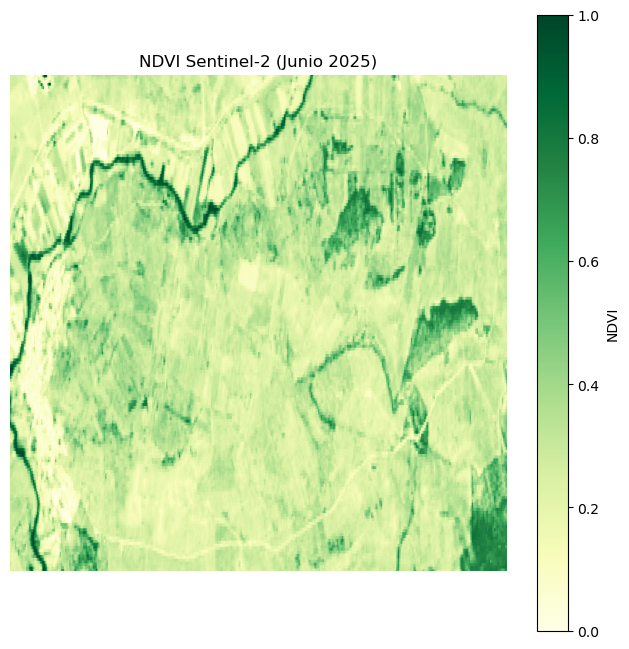

In [9]:
with rasterio.open(ndvi_data) as src:
    ndvi_array = src.read(1)

plt.figure(figsize=(8, 8))
plt.imshow(ndvi_array, cmap="YlGn", vmin=0, vmax=1)
plt.colorbar(label="NDVI")
plt.title("NDVI Sentinel-2 (Junio 2025)")
plt.axis("off")
plt.show()


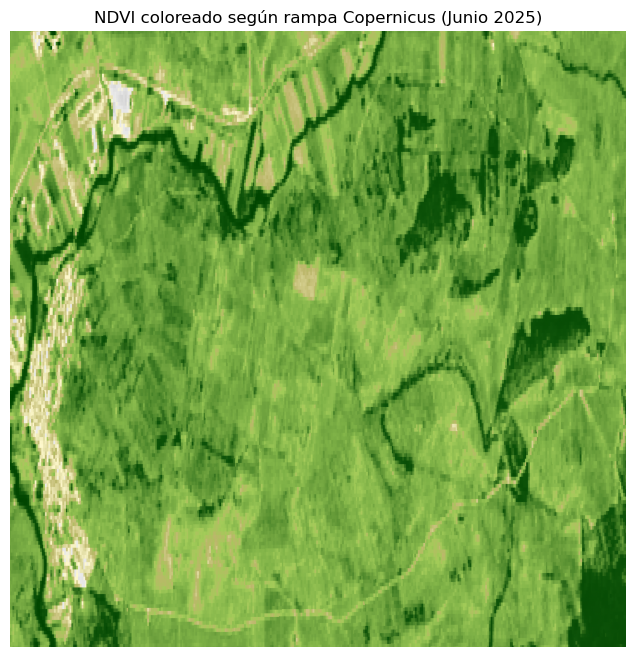

In [10]:
# vamos a probar la escala de colores sugerida por la web de Copernicus
token = get_access_token(CLIENT_ID, CLIENT_SECRET)

ndvi_data = get_image(token, BBOX, width=WIDTH, height=HEIGHT, year=2025, month=6, evalscript_ndvi=evalscript_ndvi_copernicus)

with rasterio.open(ndvi_data) as src:
    image_ndvi = src.read([1, 2, 3]) 

# Normalizar a [0, 1]
image_ndvi = image_ndvi.transpose(1, 2, 0) / 255.0

plt.figure(figsize=(8, 8))
plt.imshow(image_ndvi)
plt.title("NDVI coloreado según rampa Copernicus (Junio 2025)")
plt.axis("off")
plt.show()

plt.imsave("assets/ndvi.png", image_ndvi)


## Cálculo de anomalías

In [12]:
# Parámetros comunes
current_year = 2025
past_years = [2022, 2023, 2024]
month = 6

In [13]:
token = get_access_token(CLIENT_ID, CLIENT_SECRET)

ndvi_current = fetch_ndvi_array(
    token=token,
    bbox=BBOX,
    width=WIDTH,
    height=HEIGHT,
    year=current_year,
    month=month,
    evalscript_ndvi=evalscript_ndvi
)


In [14]:
ndvi_pasts = []

for year in past_years:
    print(f"Descargando NDVI para {year}...")
    ndvi = fetch_ndvi_array(
        token=token,
        bbox=BBOX,
        width=WIDTH,
        height=HEIGHT,
        year=year,
        month=month,
        evalscript_ndvi=evalscript_ndvi
    )
    ndvi_pasts.append(ndvi)

ndvi_pasts = np.stack(ndvi_pasts, axis=0)
ndvi_mean_past = np.nanmean(ndvi_pasts, axis=0)


Descargando NDVI para 2022...
Descargando NDVI para 2023...
Descargando NDVI para 2024...


In [19]:
anomaly = ndvi_current - ndvi_mean_past

mn, mx, md = np.nanmin(anomaly), np.nanmax(anomaly), np.nanmean(anomaly)
print(f"ΔNDVI — min: {mn:.4f}, max: {mx:.4f}, media: {md:.4f}")


ΔNDVI — min: -0.4715, max: 0.6854, media: 0.0187


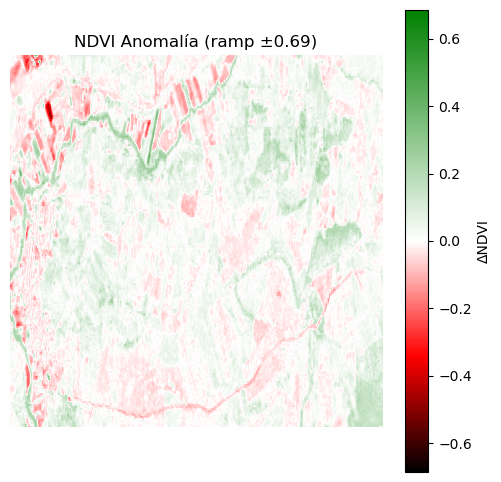

In [16]:
import matplotlib.colors as mcolors

max_abs = max(abs(mn), abs(mx))

cmap = mcolors.LinearSegmentedColormap.from_list("anom_ramp", [
    (0.0, "black"),
    (0.5 * (1 - max_abs / (2 * max_abs)), "red"),
    (0.5, "white"),
    (1.0, "green")
])
norm = mcolors.TwoSlopeNorm(vmin=-max_abs, vcenter=0, vmax=max_abs)

plt.figure(figsize=(6,6))
plt.imshow(anomaly, cmap=cmap, norm=norm)
plt.title(f"NDVI Anomalía (ramp ±{max_abs:.2f})")
plt.colorbar(label="ΔNDVI")
plt.axis("off")
plt.show()

plt.figure(figsize=(6,6))
plt.imshow(anomaly, cmap=cmap, norm=norm)
plt.axis("off")  
plt.savefig("assets/ndvi_anomaly.png", dpi=300, bbox_inches='tight', pad_inches=0)
plt.close()


Superponemos los índices en un mapa de Dash

In [ ]:

bbox = BBOX
bounds = [[bbox[1], bbox[0]], [bbox[3], bbox[2]]]
center = [(bbox[1] + bbox[3]) / 2, (bbox[0] + bbox[2]) / 2]

app = Dash(
    __name__,
    external_stylesheets=[dbc.themes.BOOTSTRAP],
    assets_folder="assets"
)

app.layout = dbc.Container([
    dbc.Row([
        dbc.Col(
            dl.Map(
                children=[
                    dl.TileLayer(
                        url="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}"
                    ),
                    dl.LayersControl(
                        position="topright",
                        children=[
                            dl.Overlay(
                                dl.ImageOverlay(
                                    url="assets/ndvi.png",
                                    bounds=bounds,
                                    opacity=0.8,
                                    crossOrigin=False
                                ),
                                name="NDVI",
                                checked=True
                            ),
                            dl.Overlay(
                                dl.ImageOverlay(
                                    url="assets/ndvi_anomaly.png",
                                    bounds=bounds,
                                    opacity=0.8,
                                    crossOrigin=False
                                ),
                                name="Anomalía NDVI",
                                checked=False
                            )
                        ]
                    )
                ],
                center=center,
                zoom=13,
                style={"width": "100%", "height": "60vh"}
            ),
            width=12
        )
    ])
])

app.run(mode="inline", debug=True)
